# JOINT LATENT SPACE EMBEDDING

This notebook reproduces the experiment on alignment of FashionMNIST latent spaces from Section C of the Supplement of our paper.

In [8]:
%%capture

import numpy as np
import pyvista as pv
import ot
import torch
from sklearn import datasets
from REW_utils import *
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import time
from sklearn.neighbors import KNeighborsClassifier
import sklearn
import seaborn as sns
import time
import seaborn as sns
torch.manual_seed(42)
np.random.seed(42)


## Data Preprocessing

In [2]:
# Use 100 samples
N = 100


# Load Two Datasets 
classes = np.load("data_latent_space_FashionMNIST/classes_fmnist.npy")[:N]
P1 = np.load("data_latent_space_FashionMNIST/ae_enc_fmnist.npy")[:N]
P2 = np.load("data_latent_space_FashionMNIST/vae_enc_fmnist.npy")[:N]
classes1 = classes
classes2 = classes
classes_org = classes

# Use 10 % Validation Split
N_test = int(P1.shape[0]/10)
classes_test = classes_org[:N_test]
classes_eval = classes_org[N_test:]

# Define Colors
cols1 = [sns.color_palette()[i] for i in classes1]
cols2 = [sns.color_palette()[i] for i in classes2]

# Define them as discrete Euclidean metric spaces with uniform weights and unit distance
X1 = GM(X=P1, mode="euclidean", gauge_mode="euclidean", squared=False, normalize_gauge=True)
X2 = GM(X=P2, mode="euclidean", gauge_mode="euclidean",squared=False, normalize_gauge=True)

## Run and Evaluate $\lambda$-embedded Wasserstein

In [7]:
eps=1e-3 # Entropic regularizer
thres = 1e-5 # Set values smaller than "thres" to 0. in embeddings

Z_type = "Plane"
max_len = 1.3 
n=20 # # Reference space is a 20x20 grid on Euclidean Square ("Plane") of size [0., 1.3]^2

lambda_GW_ls = [.01, .1, 1., 10., 100.] # Hyperparameter grid over GW entropy regularizer lambda

f_final = 1 # Worst possible FOCSTTM
for lambda_GW in lambda_GW_ls:
    m, ZZ, Z, gamma_X1,gamma_X2,zeta1,zeta2 = Wrapper_REW(X1, X2, n=n, n_its=50, eps=eps, 
                                                                         lambda_GW=lambda_GW, thres=thres,
                                                                         Z_name=Z_type, max_len=max_len)
    X1_embed = euclidean_barycenter_projection(gamma_X1, Z)
    X2_embed = euclidean_barycenter_projection(gamma_X2.transpose(0, 1), Z)
    est_dist_mat_r = torch.cdist(torch.from_numpy(X1_embed), torch.from_numpy(X2_embed)).numpy()
    f = calculate_foscttm(est_dist_mat_r[:N_test, :N_test])
    print(f"Test foscttm: {f:.3f}\n")
    if f < f_final: # We keep the embedding with the best validation foscttm
        X1_embed_final = X1_embed[N_test:]
        X2_embed_final = X2_embed[N_test:]
        est_dist_mat_r_final = est_dist_mat_r[N_test:, N_test:]
        f_final = f
        zeta1_final = zeta1
        m_fin, ZZ_fin, Z_fin = m, ZZ, Z
        gamma_X1_fin,gamma_X2_fin,zeta1_fin,zeta2_fin  = gamma_X1,gamma_X2,zeta1,zeta2

print("Final Results:")
est_dist_mat_r = est_dist_mat_r_final
print(f"foscttm:  {calculate_foscttm(est_dist_mat_r):.3f}")
neigh = KNeighborsClassifier(n_neighbors=5, metric="precomputed")
neigh.fit(est_dist_mat_r, y=classes_eval)
y_pred = neigh.predict(est_dist_mat_r)#.shape
print(f"Accuracy kNN: {sklearn.metrics.accuracy_score(classes_eval, y_pred):.3f}")
X1_embed = X1_embed_final
X2_embed = X2_embed_final

---Parameter Setting---
eps:  0.001 lambda:  0.01 Domain  Plane


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.85it/s]


Test foscttm: 0.422

---Parameter Setting---
eps:  0.001 lambda:  0.1 Domain  Plane


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.62it/s]


Test foscttm: 0.189

---Parameter Setting---
eps:  0.001 lambda:  1.0 Domain  Plane


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.98it/s]


Test foscttm: 0.033

---Parameter Setting---
eps:  0.001 lambda:  10.0 Domain  Plane


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.49it/s]


Test foscttm: 0.100

---Parameter Setting---
eps:  0.001 lambda:  100.0 Domain  Plane


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 35.99it/s]

Test foscttm: 0.056

Final Results:
foscttm:  0.040
Accuracy kNN: 0.589


## Visualize Joint Embeddings

We see that color-coded classes in the upper and lower scatter plots are aligned. 
The k-NN was also able to do domain adaptation by predicting classes.

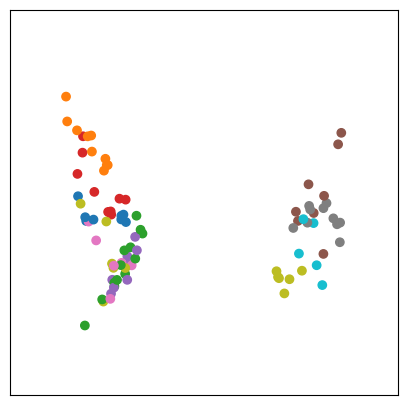

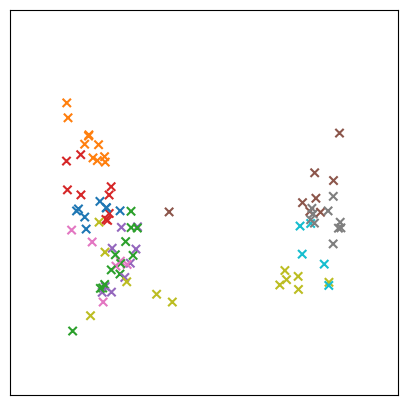

In [4]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X1_embed[:, 0],X1_embed[:, 1], c=[sns.color_palette()[c] for c in classes[N_test:]])#.shape
ax.set_xticks([])
ax.set_yticks([])
v = .7
ax.set_ylim(-v, v)
ax.set_xlim(-v, v)
plt.show()

f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X2_embed[:, 0],X2_embed[:, 1], c=[sns.color_palette()[c] for c in classes[N_test:]], marker="x")#.shape
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim(-v, v)
ax.set_xlim(-v, v)
plt.show()